# 03 Full Analysis with DuckDB


In [5]:
# 0. Imports & DuckDB connection
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 5)

DATA_FILE = Path("../data/2019-Oct.csv")
FIG_DIR = Path("../output/figures_full")
FIG_DIR.mkdir(parents=True, exist_ok=True)

con = duckdb.connect(database=":memory:")  # in-memory DB
print("DuckDB ready ✔️")


DuckDB ready ✔️


## 1. Daily & Weekly Active Users (Full CSV)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

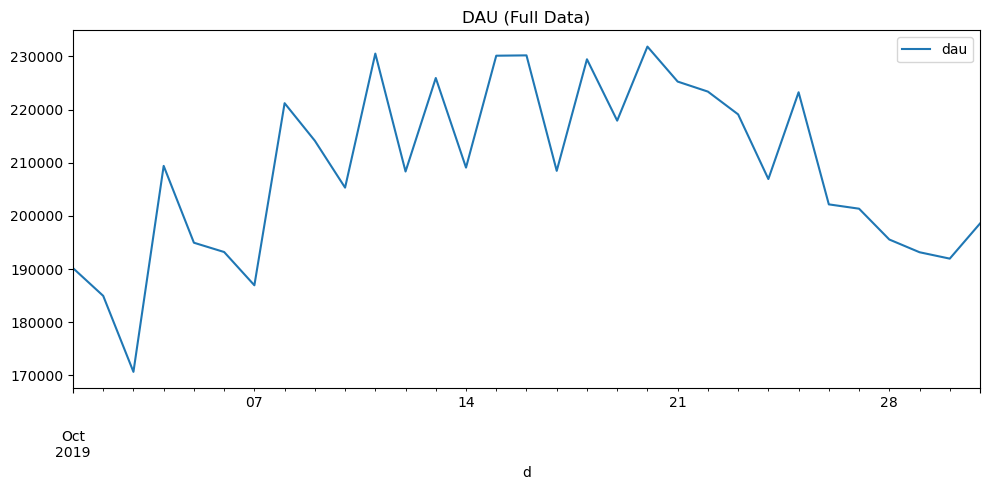

In [ ]:

query_dau = """
SELECT CAST(event_time AS DATE) AS d,
       COUNT(DISTINCT user_id) AS dau
FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000)
GROUP BY d
ORDER BY d;
"""
df_dau = con.execute(query_dau).df()

df_dau.plot(x="d", y="dau", title="DAU (Full Data)")
plt.tight_layout()
plt.savefig(FIG_DIR / "full_dau.png")
plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

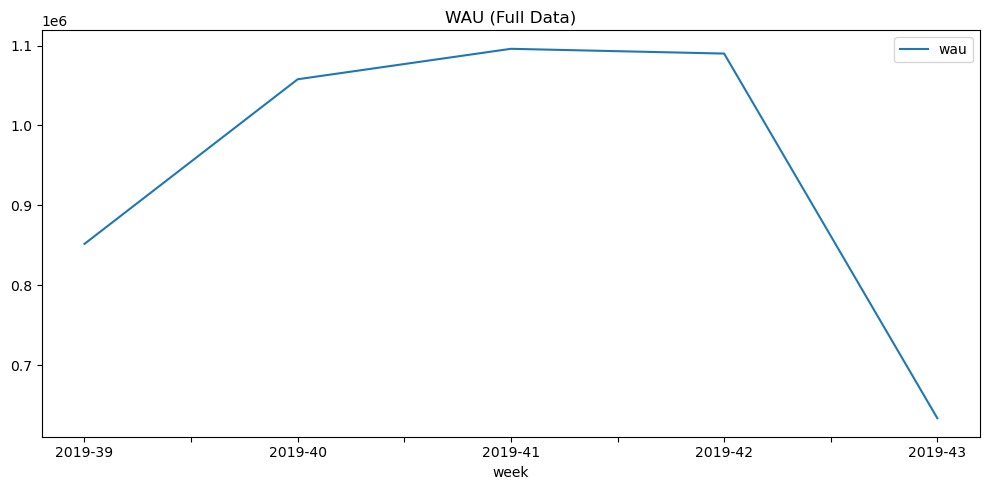

In [7]:
query_wau = """
SELECT strftime(event_time, '%Y-%W') AS week,
       COUNT(DISTINCT user_id) AS wau
FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000)
GROUP BY week
ORDER BY week;
"""
df_wau = con.execute(query_wau).df()

df_wau.plot(x="week", y="wau", title="WAU (Full Data)")
plt.tight_layout()
plt.savefig(FIG_DIR / "full_wau.png")
plt.show()


## 2. Daily Event Volume by Type


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

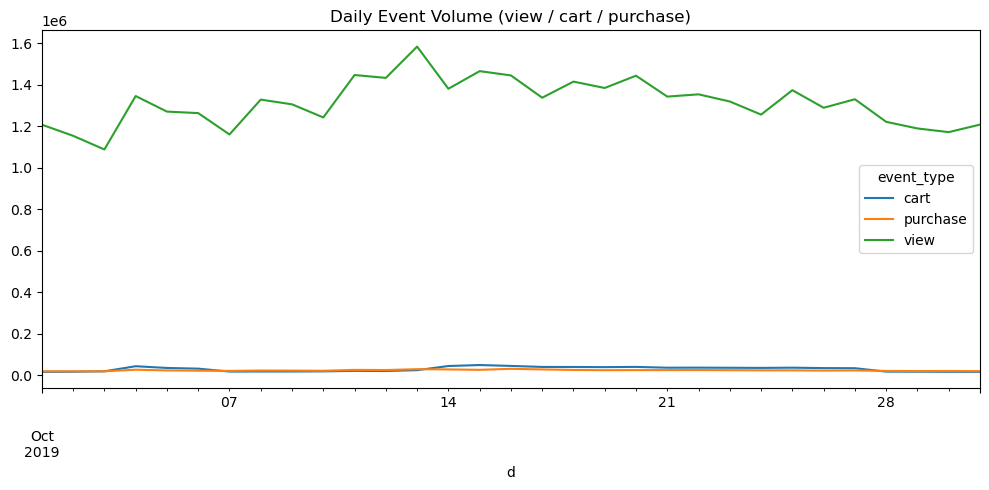

In [8]:
query_events = """
SELECT CAST(event_time AS DATE) AS d,
       event_type,
       COUNT(*) AS cnt
FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000)
GROUP BY d, event_type
ORDER BY d;
"""
df_events = con.execute(query_events).df().pivot(index="d",
                                                 columns="event_type",
                                                 values="cnt").fillna(0)

df_events.plot(title="Daily Event Volume (view / cart / purchase)")
plt.tight_layout()
plt.savefig(FIG_DIR / "full_event_trend.png")
plt.show()


## 3. View → Cart → Purchase Conversion

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

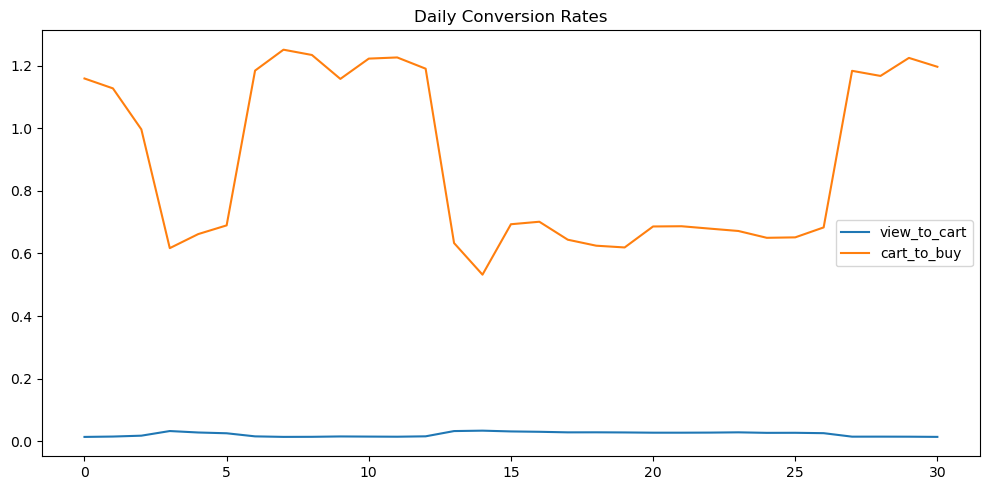

In [9]:
# 聚合浏览数、加购数、购买数
query_funnel = """
SELECT CAST(event_time AS DATE) AS d,
       SUM(event_type='view')      AS view_cnt,
       SUM(event_type='cart')      AS cart_cnt,
       SUM(event_type='purchase')  AS purchase_cnt
FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000)
GROUP BY d
ORDER BY d;
"""
df_fun = con.execute(query_funnel).df()

df_fun["view_to_cart"]   = df_fun["cart_cnt"]      / df_fun["view_cnt"]
df_fun["cart_to_buy"]    = df_fun["purchase_cnt"]  / df_fun["cart_cnt"]

df_fun[["view_to_cart", "cart_to_buy"]].plot(title="Daily Conversion Rates")
plt.tight_layout()
plt.savefig(FIG_DIR / "full_conversion.png")
plt.show()


In [10]:
## 4. Top 10 Categories & Brands

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

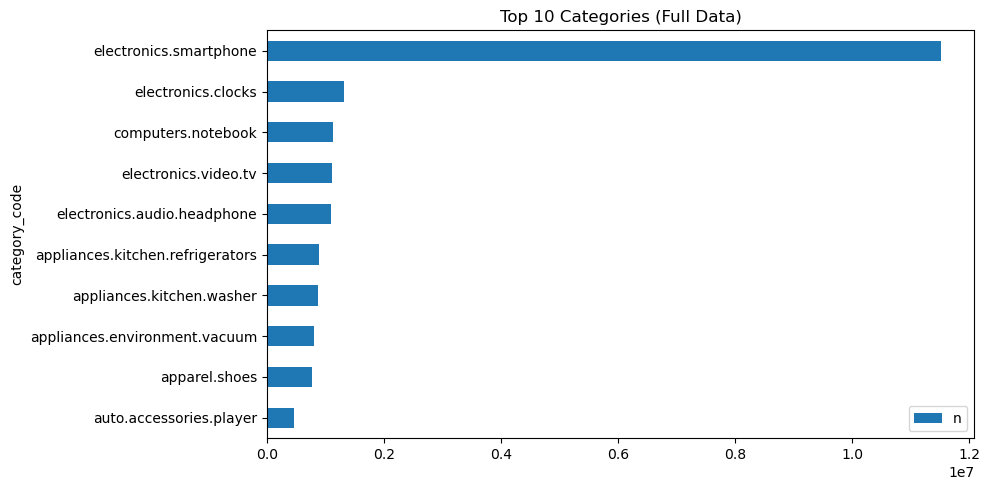

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

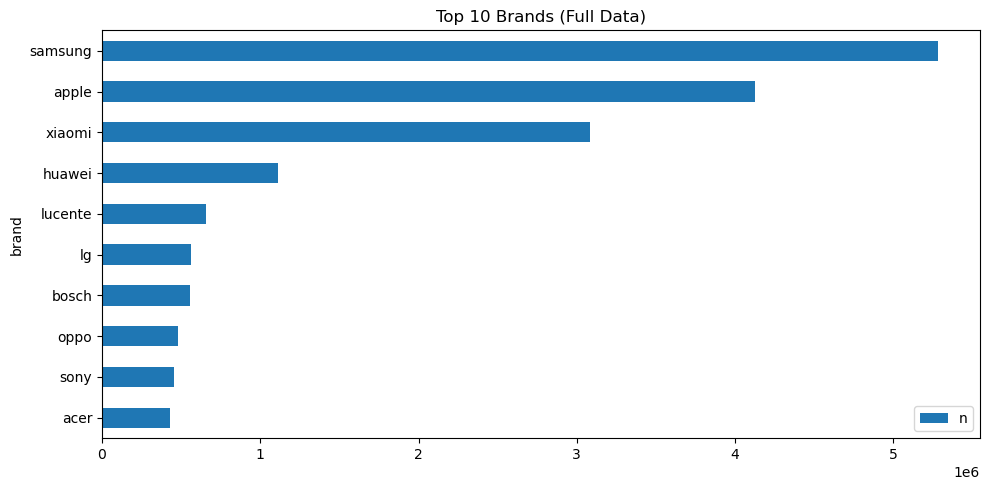

In [11]:
# Categories
cat_top = con.execute("""
    SELECT category_code, COUNT(*) AS n
    FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000)
    WHERE category_code IS NOT NULL
    GROUP BY category_code
    ORDER BY n DESC
    LIMIT 10;
""").df().sort_values("n")

cat_top.plot(kind="barh", x="category_code", y="n",
             title="Top 10 Categories (Full Data)")
plt.tight_layout()
plt.savefig(FIG_DIR / "full_top_categories.png")
plt.show()

# Brands
brand_top = con.execute("""
    SELECT brand, COUNT(*) AS n
    FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000)
    WHERE brand IS NOT NULL
    GROUP BY brand
    ORDER BY n DESC
    LIMIT 10;
""").df().sort_values("n")

brand_top.plot(kind="barh", x="brand", y="n",
               title="Top 10 Brands (Full Data)")
plt.tight_layout()
plt.savefig(FIG_DIR / "full_top_brands.png")
plt.show()


## 5. Findings & Next Steps

### 🔹 DAU / WAU
- **DAU（Daily Active Users）**：10月初日活约为185,000，月中攀升至峰值约230,000，月底略有回落至195,000左右。
- **WAU（Weekly Active Users）**：第41–42周达到顶峰约1,100,000，但在第43周骤降至约630,000。

**✅ 下一步建议**：
- 识别并挽回流失用户，特别是月底下降趋势明显的活跃用户。
- 利用月中活跃高峰进行促销或用户习惯养成（如签到、积分）策略，提升整体用户粘性。

---

### 🔹 转化率分析（Conversion Rates）
- **View → Cart**：转化率稳定在2%–3%，波动较小，月中略有回升。
- **Cart → Buy**：月初转化高达1.2%，但月中跌至0.6%–0.7%，月底回升。

**✅ 下一步建议**：
- 针对**中旬“加购不买”**问题，优化支付流程、库存提示及结账动机设计（如限时优惠、免运费等）。
- 对中旬期间用户行为进行分群分析，识别流失原因。

---

### 🔹 品类与品牌洞察（Category & Brand Insights）
- **Top 品类**：
  - 第一：`electronics.smartphone`（智能手机）流量、成交绝对领先。
  - 次级：`electronics.clocks`, `computers.notebook`, `electronics.video.tv`, `electronics.audio.headphone` 等均为百万级。

- **Top 品牌**：
  - 三星、苹果、小米分列前三，合计贡献超过50%的用户行为。
  - 中腰部品牌如华为、LG、索尼等仍具潜力。

**✅ 下一步建议**：
- 在核心品类如智能手机上投入更多资源（如开设专题页、首发频道等）。
- 针对中腰部品牌做联合推广或爆品孵化，提高品牌多样性带来的用户覆盖率。
- 精准化投放策略提升长尾品类的转化潜力。

---


### 后续
1. 留存分析（次日 / 7 日）  
2. Session-级漏斗  
3. 用户 RFM 分群  

## 6. Retention Analysis (Day‑1 & Day‑7)

In [12]:
# 1 建一个临时表 first_activity 存首日
con.execute("""
CREATE OR REPLACE TEMP VIEW first_activity AS
SELECT
    user_id,
    MIN(CAST(event_time AS DATE)) AS d0              -- 激活日期
FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000)
GROUP BY user_id;
""")
print("first_activity view created ✔️")


first_activity view created ✔️


In [13]:
# 2 取所有后续行为并计算日期差
con.execute("""
CREATE OR REPLACE TEMP VIEW activity_with_offset AS
SELECT
    fa.user_id,
    fa.d0,
    CAST(events.event_time AS DATE)        AS event_date,
    DATE_DIFF('day', fa.d0, CAST(events.event_time AS DATE)) AS day_offset
FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000) AS events
JOIN first_activity          AS fa
  ON events.user_id = fa.user_id
WHERE day_offset BETWEEN 0 AND 7;           -- 只关心 0~7 天
""")
print("activity_with_offset view created ✔️")


activity_with_offset view created ✔️


In [14]:
# 3 统计每天的激活人数 (基数) 与留存人数
query_retention = """
WITH daily_cohort AS (
    SELECT d0 AS cohort_start,
           COUNT(DISTINCT user_id) AS cohort_size
    FROM first_activity
    GROUP BY d0
),
retained AS (
    SELECT
        d0                    AS cohort_start,
        day_offset,
        COUNT(DISTINCT user_id) AS retained_users
    FROM activity_with_offset
    GROUP BY 1, 2
)
SELECT
    r.cohort_start,
    r.day_offset,
    retained_users,
    d.cohort_size,
    retained_users * 1.0 / d.cohort_size AS retention_rate
FROM retained r
JOIN daily_cohort d USING (cohort_start)
ORDER BY cohort_start, day_offset;
"""
df_ret = con.execute(query_retention).df()
print(df_ret.head())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  cohort_start  day_offset  retained_users  cohort_size  retention_rate
0   2019-10-01           0          190188       190188        1.000000
1   2019-10-01           1           32862       190188        0.172787
2   2019-10-01           2           25730       190188        0.135287
3   2019-10-01           3           27956       190188        0.146991
4   2019-10-01           4           23299       190188        0.122505


In [15]:
# 4 透视成矩阵形式
ret_matrix = (
    df_ret.pivot(index="cohort_start",
                 columns="day_offset",
                 values="retention_rate")
    .fillna(0)
    .round(3)
)
ret_matrix.head()


day_offset,0,1,2,3,4,5,6,7
cohort_start,,,,,,,,
2019-10-01,1.0,0.173,0.135,0.147,0.123,0.115,0.113,0.118
2019-10-02,1.0,0.136,0.131,0.105,0.098,0.094,0.100,0.097
2019-10-03,1.0,0.147,0.105,0.094,0.091,0.096,0.092,0.086
2019-10-04,1.0,0.123,0.092,0.084,0.088,0.082,0.079,0.091
2019-10-05,1.0,0.116,0.081,0.079,0.074,0.069,0.079,0.073


平均次日留存: 9.82%
平均7日留存 : 4.55%


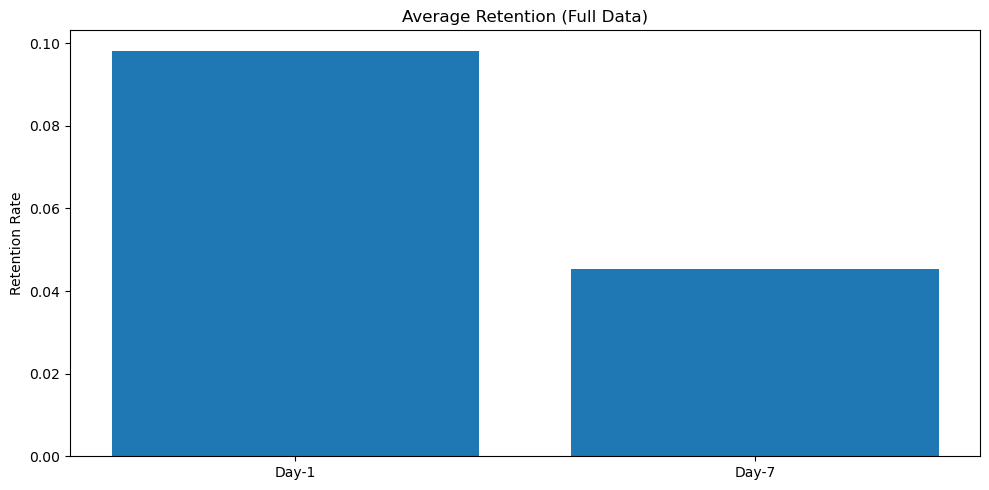

In [16]:
day1_mean = ret_matrix[1].mean()
day7_mean = ret_matrix[7].mean()

print(f"平均次日留存: {day1_mean:.2%}")
print(f"平均7日留存 : {day7_mean:.2%}")

# 柱状可视化
plt.figure()
plt.bar(["Day‑1", "Day‑7"], [day1_mean, day7_mean])
plt.ylabel("Retention Rate")
plt.title("Average Retention (Full Data)")
plt.tight_layout()
plt.savefig(FIG_DIR / "full_retention_bar.png")
plt.show()


### Retention Findings
| 指标 | 平均值 |
| ---- | ------ |
| **Day‑1** | 9.82 % |
| **Day‑7** | 4.55 % |

> • Cohort 分析显示…  
> • 建议针对 Day‑1 流失用户设置提醒/优惠 …  


## 7. RFM Segmentation

In [17]:
# 建临时视图：purchase_events 只留购买记录
con.execute("""
CREATE OR REPLACE TEMP VIEW purchase_events AS
SELECT
    user_id,
    CAST(event_time AS DATE)      AS purchase_date,
    price                         AS amount
FROM read_csv_auto('../data/2019-Oct.csv', sample_size=50000)
WHERE event_type = 'purchase';
""")
print("purchase_events view created ✔️")


purchase_events view created ✔️


In [18]:
# 设定“分析基准日”＝ 数据集最后一天
analysis_date = con.execute(
    "SELECT MAX(purchase_date) FROM purchase_events"
).fetchone()[0]

query_rfm = f"""
SELECT
    user_id,
    DATE_DIFF('day', MAX(purchase_date), DATE '{analysis_date}') AS Recency,
    COUNT(*)                                       AS Frequency,
    SUM(amount)                                    AS Monetary
FROM purchase_events
GROUP BY user_id;
"""
df_rfm = con.execute(query_rfm).df()
df_rfm.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,user_id,Recency,Frequency,Monetary
0,554943555,0,26,659.16
1,552309094,14,3,979.37
2,555475689,8,25,13221.76
3,527977263,30,1,111.79
4,514436810,30,1,365.49


In [19]:
# 分位数切分
quantiles = df_rfm[["Recency", "Frequency", "Monetary"]].quantile([.2, .4, .6, .8])

def r_score(x):
    # Recency 越小越好 => 反向
    return 5 - sum(x > quantiles["Recency"])

def fm_score(x, col):
    return sum(x > quantiles[col]) + 1

df_rfm["R"] = df_rfm["Recency"].apply(r_score)
df_rfm["F"] = df_rfm["Frequency"].apply(lambda x: fm_score(x, "Frequency"))
df_rfm["M"] = df_rfm["Monetary"].apply(lambda x: fm_score(x, "Monetary"))

df_rfm["RFM_Score"] = df_rfm["R"].astype(str) + df_rfm["F"].astype(str) + df_rfm["M"].astype(str)
df_rfm.head()


,user_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,554943555,0,26,659.16,5,5,4,554
1,552309094,14,3,979.37,3,5,5,355
2,555475689,8,25,13221.76,4,5,5,455
3,527977263,30,1,111.79,1,1,2,112
4,514436810,30,1,365.49,1,1,4,114


In [20]:
def segment(r, f, m):
    if r >=4 and f >=4 and m >=4:
        return "Champions"
    if r >=4 and f >=3:
        return "Loyal"
    if r >=3 and m >=4:
        return "Big Spenders"
    if r >=4:
        return "Recent"
    if f >=4:
        return "Frequent"
    if m >=4:
        return "High Revenue"
    return "Others"

df_rfm["Segment"] = df_rfm.apply(lambda row: segment(row["R"], row["F"], row["M"]), axis=1)

seg_cnt = df_rfm["Segment"].value_counts()
print(seg_cnt)

# ✅ 保存 RFM 分群结果为 CSV 文件，用于 Streamlit 看板展示
df_rfm.to_csv("../output/rfm_segments.csv", index=False)



Segment
Others          108927
Recent           57625
Champions        47709
Big Spenders     46445
Frequent         46412
High Revenue     21320
Loyal            18680
Name: count, dtype: int64


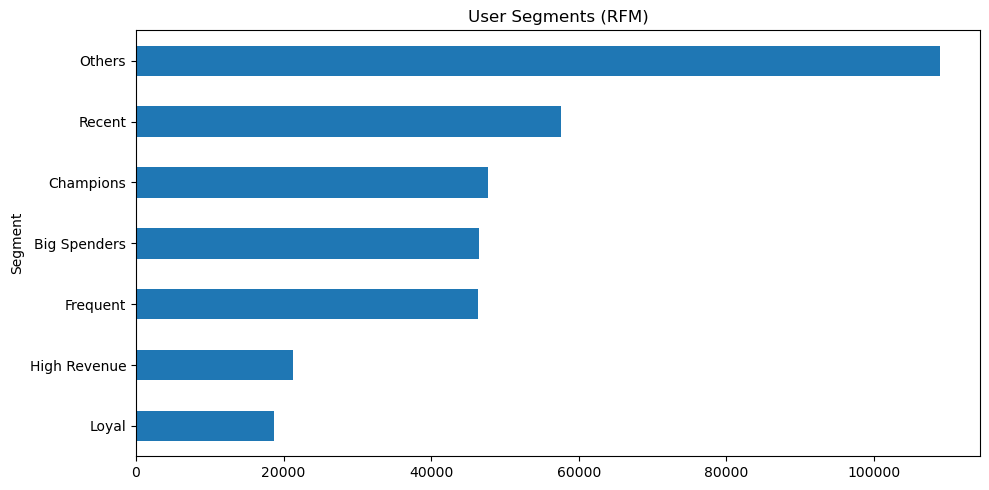

In [21]:
plt.figure()
seg_cnt.sort_values().plot(kind="barh", title="User Segments (RFM)")
plt.tight_layout()
plt.savefig(FIG_DIR / "rfm_segments.png")
plt.show()


### RFM Insights
| Segment      | 用户数     | 洞察 / 建议           |
| ------------ | ------- | ----------------- |
| Champions    | 47,709  | 重点维护，推送专属优惠和提前购资格 |
| Loyal        | 18,680  | 激励复购频率，建设会员成长体系   |
| Big Spenders | 46,445  | 推高端新品，定期送出 VIP 礼遇 |
| Recent       | 57,625  | 发欢迎优惠券，引导完成首次复购   |
| Frequent     | 46,412  | 推积分兑换、捆绑销售提升客单    |
| High Revenue | 21,320  | 推高单价礼包产品，开展感恩反馈活动 |
| Others       | 108,927 | 尝试挽回，发送召回提醒或折扣促活  |
